In [4]:
import os
import ants
import logging
import xlsxwriter
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import math_img, resample_to_img, get_data, load_img
from nilearn.plotting import plot_anat, plot_img

In [6]:
# Fetch the Harvard-Oxford atlas
try:
    ATLAS = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
    # Load the atlas image
    ATLAS_IMAGE = load_img(ATLAS.maps)
    ATLAS_DATA = get_data(ATLAS_IMAGE)
    # Extract region names from the atlas
    LABEL_NAMES = ATLAS['labels']
    # Extract unique region labels from the atlas
    REGION_LABELS = np.unique(ATLAS_DATA)
except Exception as e:
    logging.error(f"Error fetching/loading Harvard-Oxford atlas: {e}")
    raise  # In many cases, you'd want to stop execution if the atlas isn't available.

[get_dataset_dir] Dataset found in /Users/mayerunterberg/nilearn_data/fsl


In [46]:
def get_subject_file_pairs(data_dir, subjectDF):
    """
    Given a DataFrame of participants and a data directory,
    locate subject baseline (BL) and follow-up (FU) files
    and store them in the DataFrame columns.
    """
    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)

        # Skip non-directories or irrelevant files
        if not os.path.isdir(subject_path) or subject.startswith('.') or subject == 'derivatives':
            continue

        for index, row in subjectDF.iterrows():
            subject = row['participant_id']
            subject_path = os.path.join(data_dir, f"sub-{subject:03d}")

            # Locate BL and FU files
            baseline_file = os.path.join(subject_path, 'ses-BL', 'anat', f"sub-{subject:03d}_ses-BL_T1w.nii.gz")
            followup_file = os.path.join(subject_path, 'ses-FU', 'anat', f"sub-{subject:03d}_ses-FU_T1w.nii.gz")

            # Verify that both files exist
            if os.path.exists(baseline_file) and os.path.exists(followup_file):
                # Add the file paths to the DataFrame
                subjectDF.at[index, 'Baseline File Path'] = 'Data/' + os.path.relpath(baseline_file, data_dir)
                subjectDF.at[index, 'Followup File Path'] = 'Data/' + os.path.relpath(followup_file, data_dir)
            else:
                print(f"Skipping subject {subject}: missing files.")

In [47]:
def register_and_convert_to_nifti(fixed_image, moving_image, subject_id, session, transform_type='Affine'):
    """
    Registers `moving_image` to `fixed_image` using ANTs, writes out the
    transformed result to disk as a NIfTI file, and returns the nibabel image.
    """
    # Construct the output filename
    out_path = f"output/registered_output_sub-{subject_id}_ses-{session}.nii.gz"
    # If the file already exists, just load it and skip registration
    if os.path.exists(out_path):
        try:
            file = nib.load(out_path)
        except Exception as e:
            logging.error(f"Error registering images for subject {subject_id} session {session}: {e}")
            raise
        return file

    moving_image = ants.n4_bias_field_correction(moving_image)
    moving_image = ants.smooth_image(moving_image, 2)

    # Otherwise performs the registration
    outputImage = ants.registration(
        fixed=fixed_image,
        moving=moving_image,
        type_of_transform=transform_type
    )['warpedmovout']
    
    # mask = ants.get_mask(outputImage)
    # seg_results = ants.atropos(
    #     a=outputImage,
    #     x=mask,               # Optional mask of the brain if you have it
    #     i='KMeans[3]',       # 3 classes: GM, WM, CSF
    #     m='[0.1, 1x1x1]',      # smoothing + mask dilation settings
    #     c='[5,0]'
    # )

    # # 2. Create a GM mask: True where segmentation == 1
    # outputImage = ants.mask_image(
    #     image=registered,          # your T1 ANTsImage
    #     mask=seg_results['segmentation'],
    #     level=1                    # the label for GM in your segmentation
    # )

    # Write out to disk
    out_path = f"output/registered_output_sub-{subject_id}_ses-{session}.nii.gz"
    ants.image_write(outputImage, out_path)
    try:
        file = nib.load(out_path)
    except Exception as e:
        logging.error(f"Error registering images for subject {subject_id} session {session}: {e}")
        raise
    return file

def loadImage(imgPath, subject_id, session):
    """
    Reads an image from a given path, then registers it against the
    Harvard-Oxford atlas, returning a NIfTI image resampled to the atlas space.
    """
    atlasPath = '/Users/mayerunterberg/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz'
    atlas_image = ants.image_read(atlasPath)
    ants_img = ants.image_read(imgPath)
    
    # Register and convert to NIfTI
    nifti = register_and_convert_to_nifti(
            fixed_image=atlas_image,
            moving_image=ants_img,
            subject_id=subject_id,
            session=session
        )
        
    img_resampled = resample_to_img(
        source_img=nifti,
        target_img=ATLAS_IMAGE,
        force_resample=True,
        copy_header=True,
        interpolation='nearest'
    )
    return img_resampled

def findDifferingAreasAndVolume(index, df, img1, img2, threshold=None):
    """
    Given two images, computes the difference map, calculates mean difference
    and volume changes per region, and records those metrics in the DataFrame.
    """
    # 1) Create the difference map
    diff = math_img("img1 - img2", img1=img1, img2=img2)
    diff_data = get_data(diff)
    
    # 2) For volume calculations, get data for each image
    img1_data = get_data(img1)
    img2_data = get_data(img2)
    
    # 3) We also need voxel volume, typically from the ATLAS_IMAGE’s affine
    # or if each registered image uses the same affine, we can use img1.affine
    voxel_sizes = np.abs(np.diag(ATLAS_IMAGE.affine)[:3])  # shape (3,)
    voxel_volume = np.prod(voxel_sizes)  # in mm^3
    # Loop through each region to compute statistics
    for label in REGION_LABELS:
        # regionMask indicates voxels belonging to this label
        # Determine region name
        if 0 <= label < len(LABEL_NAMES):
            region_name = LABEL_NAMES[label]
        else:
            region_name = "Unknown Region"
            continue
        if region_name in ("Background"):
            continue

        regionMask = (ATLAS_DATA == label)
        
        # A) Mean difference
        regionChanges = diff_data[regionMask]
        region_mean_diff = round(float(np.mean(regionChanges)), 2)
        
        # B) Volume difference
        # Count nonzero (or > 0) voxels in each image within the region
        # In structural MRI, you might need a threshold or binarization approach.
        # For a simple approach, let's count all *non-zero* voxels in that region:
        if threshold is not None:
            img1_masked = ((img1_data > threshold) & regionMask)
            img2_masked = ((img2_data > threshold) & regionMask)
        else:
            img1_masked = ((img1_data != 0) & regionMask)
            img2_masked = ((img2_data != 0) & regionMask)
            
        region_img1_voxels = np.count_nonzero(img1_masked)
        region_img2_voxels = np.count_nonzero(img2_masked)
        
        region_img1_volume = region_img1_voxels * voxel_volume
        region_img2_volume = region_img2_voxels * voxel_volume
        region_volume_diff = round(region_img1_volume - region_img2_volume, 2)
        avgVolume = round((region_img1_volume + region_img2_volume) / 2, 2)
        
        # Save to the DataFrame
        df.loc[index, f"{region_name} Change"] = region_mean_diff
        df.loc[index, f"{region_name} Volume Avg"] = avgVolume
        df.loc[index, f"{region_name} Volume Change"] = region_volume_diff

In [49]:
participants_df = pd.read_csv('Data/participants.tsv', sep="\t")
# Add columns for file paths
# Prepare all the new column names
new_cols = {}
filePaths = ['Baseline File Path', 'Followup File Path']
for label in filePaths:
    new_cols[f"{label}"] = [None]*len(participants_df)
for label in LABEL_NAMES:
    if label in ("Background", "Unknown Region"):
        continue
    new_cols[f"{label} Volume Avg"] = [None]*len(participants_df)
for label in LABEL_NAMES:
    if label in ("Background", "Unknown Region"):
        continue
    new_cols[f"{label} Volume Change"] = [None]*len(participants_df)
for label in LABEL_NAMES:
    if label in ("Background", "Unknown Region"):
        continue
    new_cols[f"{label} Change"] = [None]*len(participants_df)

# Create an empty DataFrame with those columns
columns_df = pd.DataFrame(new_cols, index=participants_df.index)

# Concatenate horizontally (axis=1)
participants_df = pd.concat([participants_df, columns_df], axis=1)
get_subject_file_pairs('Data', participants_df)

In [50]:
for idx, row in participants_df.iterrows():
    baseLinePath = row['Baseline File Path']
    followUpPath = row['Followup File Path']
    if pd.isna(baseLinePath) or pd.isna(followUpPath):
        continue  # skip if missing file
    baseLine = loadImage(baseLinePath, row['participant_id'], 'BL')
    followUp = loadImage(followUpPath, row['participant_id'], 'FU')
    findDifferingAreasAndVolume(idx, participants_df, baseLine, followUp)

In [51]:
import subprocess
output_excel_path = 'participants_with_changes.xlsx'

# Use the XlsxWriter engine so we can format cells
with pd.ExcelWriter(output_excel_path, engine='xlsxwriter') as writer:
    participants_df.to_excel(writer, index=False, sheet_name='Sheet1')
    workbook = writer.book
    worksheet = writer.sheets['Sheet1']
    cell_format = workbook.add_format({
        'font_size': 14,
        'align': 'center',
        'valign': 'vcenter'
    })
    for col_num, col_name in enumerate(participants_df.columns):
        column_data = participants_df[col_name].astype(str)
        max_len = max(column_data.map(len).max(), len(col_name))
        worksheet.set_column(col_num, col_num, max_len + 2, cell_format)
subprocess.run(["open", output_excel_path])

CompletedProcess(args=['open', 'participants_with_changes.xlsx'], returncode=0)

In [52]:
participants_df['avg cudit'] = (participants_df['cudit total baseline'] + participants_df['cudit total follow-up']) / 2
cudit_columns = ['avg cudit']
brain_region_columns = [col for col in participants_df.columns if 'Change' in col]
# Combine into one dataset
correlation_data = participants_df[cudit_columns + brain_region_columns]
# Compute correlations
correlation_matrix = correlation_data.corr()
cudit_correlations = correlation_matrix.loc[cudit_columns, brain_region_columns]
#cudit_correlations.T.sort_values(by='avg cudit', ascending=False)

In [111]:
def display_brain_and_difference(baseLinePath, followUpPath):
    """
    Displays the brain images for baseline, follow-up, and their difference.
    If diffPath is not provided, it calculates the difference.
    
    Parameters:
    - baseLinePath: Path to the baseline MRI file (NIfTI format).
    - followUpPath: Path to the follow-up MRI file (NIfTI format).
    """
    # Load the baseline and follow-up images
    baseline_img = nib.load(baseLinePath)
    followup_img = nib.load(followUpPath)
    
    # Calculate the difference if not provided
    baseline_data = baseline_img.get_fdata()
    followup_data = followup_img.get_fdata()
    diff_data = followup_data - baseline_data
    diff_img = nib.Nifti1Image(diff_data, affine=baseline_img.affine)

    # Plot the follow-up image
    plot_img(diff_img, title="Difference MRI", cmap='coolwarm', colorbar=True)
    
    # Show the plot
    plt.show()

    # Plot the follow-up image
    plot_anat(followup_img, title="Follow-Up MRI")
    plot_anat(baseline_img, title="Baseline MRI")
    
    # Show the plot
    plt.show()

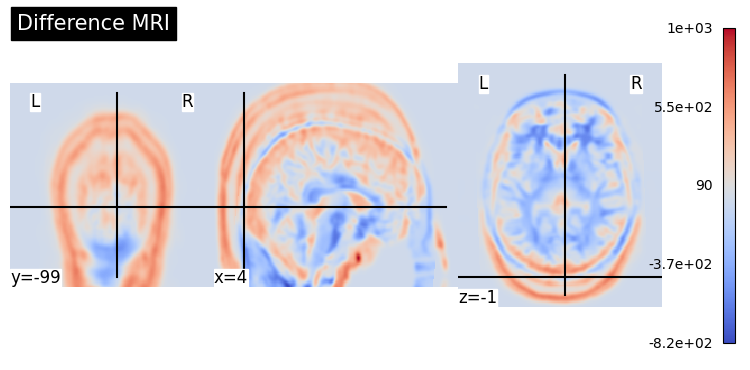

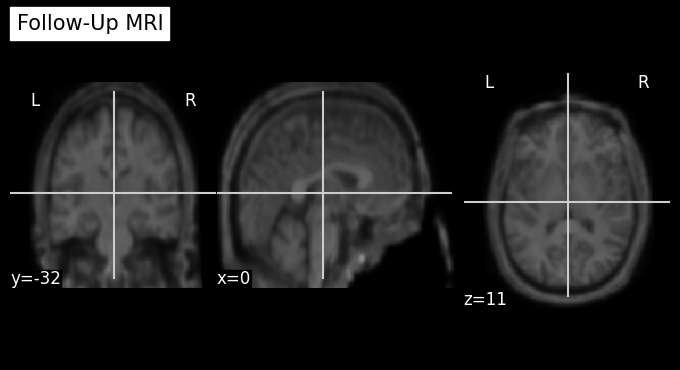

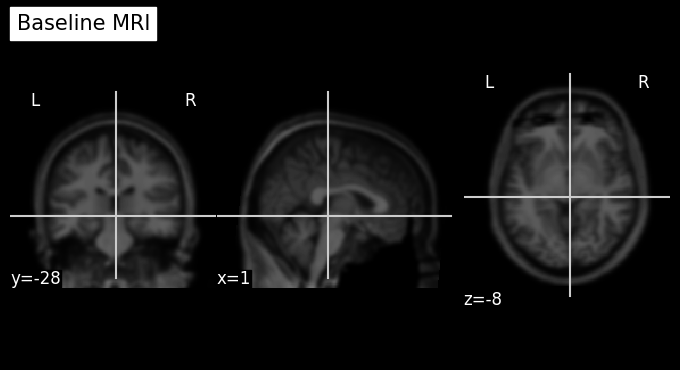

In [112]:
# Example usage:
baseline_file = 'output/registered_output_sub-123_ses-BL.nii.gz'  # Replace with your baseline file path
followup_file = 'output/registered_output_sub-123_ses-FU.nii.gz'  # Replace with your follow-up file path
display_brain_and_difference(baseline_file, followup_file)